In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Warning: Package ReactiveMP does not have LineSearches in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added LineSearches as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading LineSearches into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
# clean speech
cl, fs = wavread("speech/clean.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "speech/noised.wav")

In [3]:
# dividing into 10ms frames with 2.5ms overlap
start = 1
l = Int(round(0.01*fs))
overlap = Int(round(0.0025*fs))
totseg = Int(ceil(length(ns)/(l-overlap)))
segment = zeros(totseg, l)
zseg = zeros(totseg, l)
for i in 1:totseg - 1
    global start
    segment[i,1:l]=ns[start:start+l-1]
    zseg[i, 1:l] = cl[start:start+l-1]
    start = (l-overlap)*i+1
end
segment[totseg, 1:length(ns)-start+1] = ns[start:length(ns)]
zseg[totseg, 1:length(cl)-start+1] = cl[start:length(cl)];

In [4]:
function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [31]:
@model function lar_model(n, order, artype, c)

    x = randomvar(n)
    y = datavar(Float64, n)

    γ ~ GammaShapeRate(0.00001, 1.0) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(randn(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(100.0 * ones(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}

    x_prev = x0

    ct  = constvar(c)
    γ_y = constvar(inv(0.0001))

    ar_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order, ARsafe()) }

        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), γ_y) where {q=MeanField()}

        x_prev = x[i]
    end

    return x, y, θ, γ, ar_nodes
end

lar_model (generic function with 1 method)

In [32]:
function inference_lar(data, order, niter)
    n = length(data)
    artype = Multivariate
    c = zeros(order); c[1] = 1.0
    model, (x, y, θ, γ, ar_nodes) = lar_model(n, order, artype, c)

    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))

    for i in 1:n
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(100.0 * ones(2*order), Matrix{Float64}(I, 2*order, 2*order)))
    end

    for i in 1:niter
        update!(y, data)
    end

    unsubscribe!(γsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return γ_buffer, θ_buffer, x_buffer, fe
end

inference_lar (generic function with 1 method)

In [33]:
@model function gaussian_model(n)

    y = datavar(Float64, n)

    γ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}
    x ~ NormalMeanPrecision(0.0, 1.0) where {q=MeanField()}

    for i in 1:n
        y[i] ~ NormalMeanPrecision(x, γ) where {q=MeanField()}
    end

    return y, x, γ
end

gaussian_model (generic function with 1 method)

In [34]:
function inference_gaussian(outputs, niter)
    n = length(outputs)
    model, (y, x, γ) = gaussian_model(n, options = (limit_stack_depth = 500, ))

    γ_buffer = nothing
    x_buffer = nothing
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (my) -> γ_buffer = my)
    xsub = subscribe!(getmarginal(x), (mx) -> x_buffer = mx)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))

    for i in 1:niter
        update!(y, outputs)
    end

    unsubscribe!(γsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return x_buffer, γ_buffer, fe
end

inference_gaussian (generic function with 1 method)

In [56]:
ar_order = 1
vmp_iter = 10
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [57]:
ProgressMeter.@showprogress for segnum in 100:120
    inputs, outputs = ar_ssm(segment[segnum, :], ar_order)
    γ, θ, x, fe = inference_lar(outputs, ar_order, vmp_iter)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [58]:
minimum(fe_ar[1:end-1, :])

-13.861258760096348

In [59]:
minimum(fe_gaussian)

-31.70147088109715

In [60]:
fe_ar[100:120, :]

21×10 Matrix{Float64}:
 552.758  -12.8371  -13.3569  -13.357   …  -13.357   -13.357   -13.357
 552.274  -13.3396  -13.8593  -13.8594     -13.8594  -13.8594  -13.8594
 552.305  -13.3418  -13.8612  -13.8613     -13.8613  -13.8613  -13.8613
 552.491  -13.2521  -13.7714  -13.7715     -13.7715  -13.7715  -13.7715
 554.301  -11.2199  -11.74    -11.74       -11.74    -11.74    -11.74
 552.461  -13.3039  -13.8235  -13.8236  …  -13.8236  -13.8236  -13.8236
 552.392  -13.252   -13.7712  -13.7712     -13.7712  -13.7712  -13.7712
 552.455  -13.1463  -13.6671  -13.6672     -13.6672  -13.6672  -13.6672
 552.466  -13.141   -13.6607  -13.6608     -13.6608  -13.6608  -13.6608
 552.595  -13.0982  -13.6171  -13.6172     -13.6172  -13.6172  -13.6172
 553.628  -11.9688  -12.4874  -12.4875  …  -12.4875  -12.4875  -12.4875
 552.622  -13.0039  -13.5223  -13.5224     -13.5224  -13.5224  -13.5224
 552.698  -12.949   -13.4666  -13.4667     -13.4667  -13.4667  -13.4667
 552.913  -12.6279  -13.1391  -13.1392     -

In [54]:
fe_gaussian[100:120, :]

21×10 Matrix{Float64}:
 -11.6259  -23.6814  -23.7229  -23.7229  …  -23.7229  -23.7229  -23.7229
 -11.6312  -23.6891  -23.7306  -23.7307     -23.7307  -23.7307  -23.7307
 -11.6156  -23.6663  -23.7077  -23.7078     -23.7078  -23.7078  -23.7078
 -11.61    -23.658   -23.6995  -23.6995     -23.6995  -23.6995  -23.6995
 -11.6153  -23.6658  -23.7073  -23.7073     -23.7073  -23.7073  -23.7073
 -11.6272  -23.6832  -23.7247  -23.7247  …  -23.7247  -23.7247  -23.7247
 -11.6132  -23.6627  -23.7042  -23.7042     -23.7042  -23.7042  -23.7042
 -11.6764  -23.7555  -23.7972  -23.7972     -23.7972  -23.7972  -23.7972
 -11.6366  -23.6971  -23.7386  -23.7386     -23.7386  -23.7386  -23.7386
 -11.6008  -23.6445  -23.686   -23.686      -23.686   -23.686   -23.686
 -11.5618  -23.5874  -23.6288  -23.6288  …  -23.6288  -23.6288  -23.6288
 -11.5937  -23.6341  -23.6755  -23.6756     -23.6756  -23.6756  -23.6756
 -11.5614  -23.5867  -23.6281  -23.6281     -23.6281  -23.6281  -23.6281
 -11.2794  -23.1743  -23.2148

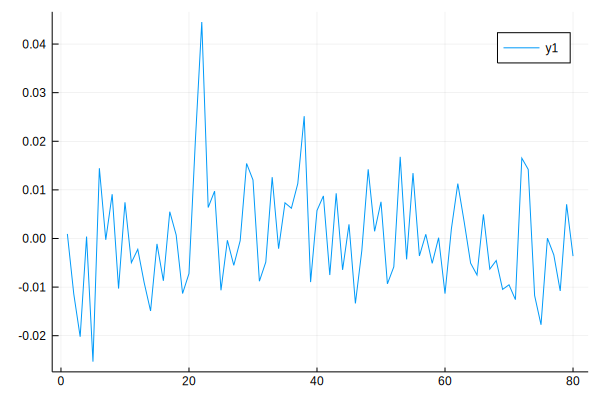

In [61]:
plot(segment[120, :])